# Zillow Project

## Goal:

* To find the key drivers of property value for single family properties and attempt to predict their future values.

## Imports:

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Acquire/Prep Imports
from env import get_db_url
import os
import wrangle as w

## Acquire:

* Data acquired from MySQL Codeup Server
* Dataframe contained 52,442 Rows and 10 Columns before Cleaning.
* Each Row represents a single family home that has been sold some time in 2017.
* Each Column represents the specifics of the home, how many rooms, bathrooms, square footage, etc.

## Prepare:

### Prepare Actions

* Renamed Columns:

    * 'fips': 'county', 'bedroomcnt': 'bedrooms', 'garagecarcnt': 'garage_fits', 'bathroomcnt': 'bathrooms', 'garagetotalsqft': 'garage_area', 'calculatedfinishedsquarefeet': 'finished_area', 'lotsizesquarefeet': 'lot_area', 'taxvaluedollarcnt': 'home_value'



* Filled Null Values:

    * garage data had alot of null values; updated to '0'
        - further investigation showed that 'LA' County did not have the data for garages.
        - 'Orange' and 'Ventura' counties had garage data.



* Dropped the Rest of the Nulls:

    * 'yearbuilt', 'finished_area', 'lot_area', and 'home_value' had minimal null values( < .1% of data ).



* Changed County Values: 

    * 6037: 'LA', 6059: 'Orange', 6111: 'Ventura'



* Dropped Outliers for bedrooms:

    * Dropped homes with more than 8  and less than 1 bedrooms.



* Encoded County:

    * Encoded for modeling.



* Split data into Train, Validate, and Test (56/24/20), Target was 'home_value'



* Dropped 'transactiondate':

    * Was used to pull dataset from MySql to ensure we were looking at the right data.

* Dropped the 1st and last 1% of home_value column to deal with outliers

| Feature | Definition |
|--------|-----------|
|Bedrooms| Number of Bedrooms|
|Bathrooms| Number of Bathrooms|
|Finished Area| Usable Square Footage of Home|
|Home Value| Price of Home|
|Year Built| Year house was built|
|Lot Area| Square Footage of the entire property lot|
|County| County location of home|
|Garage Fits| Number of Cars that Fit in Garage|
|Garage Area| Square Footage of the Garage|
|Transaction Date| Last time the house was sold in 2017|


In [2]:
# Acquiring and Prepping Data
df = w.get_zillow()
df = w.prep_zillow(df)

## Explore

### A brief look at the data

In [3]:
df.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
0,4,3.5,3100.0,1023282.0,1998,4506.0,Orange,2,633.0
1,2,1.0,1465.0,464000.0,1967,12647.0,Ventura,1,0.0
2,3,2.0,1243.0,564778.0,1962,8432.0,Orange,2,440.0
3,4,3.0,2376.0,145143.0,1970,13038.0,LA,0,0.0
4,4,3.0,2962.0,773303.0,1950,63000.0,LA,0,0.0


### A summary of the data

In [4]:
w.check_columns(df)



,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
7,garage_fits,12,"[2, 1, 0, 3, 5, 4, 7, 6, 8, 9, 13, 14]",0,0.0,int64
1,bathrooms,17,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 1.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998, 1967, 1962, 1970, 1950, 1922, 1999, 198...",0,0.0,int64
8,garage_area,808,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4404,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,13874,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,37615,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


In [5]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,50841.0,3.304911,0.907431,1.0,3.0,3.0,4.0,8.0
bathrooms,50841.0,2.280758,0.949481,1.0,2.0,2.0,3.0,10.0
finished_area,50841.0,1891.458606,893.010819,152.0,1274.0,1657.0,2286.0,11020.0
home_value,50841.0,481543.801046,434316.463331,37431.0,197341.0,372917.0,609150.0,3076800.0
yearbuilt,50841.0,1963.433961,22.705263,1878.0,1950.0,1961.0,1979.0,2016.0
lot_area,50841.0,11065.639740,87341.829496,236.0,5595.0,6830.0,8716.0,6971010.0
garage_fits,50841.0,0.678389,0.975550,0.0,0.0,0.0,2.0,14.0
garage_area,50841.0,172.487343,251.199144,0.0,0.0,0.0,433.0,4251.0


### Data Split

In [6]:
# split into train, validat, test
train, validate, test = w.split_data(df)

Train: 0.5599811176019355
Validate: 0.2400031470663441
Test: 0.20001573533172046


### How do bedrooms affect home_value?


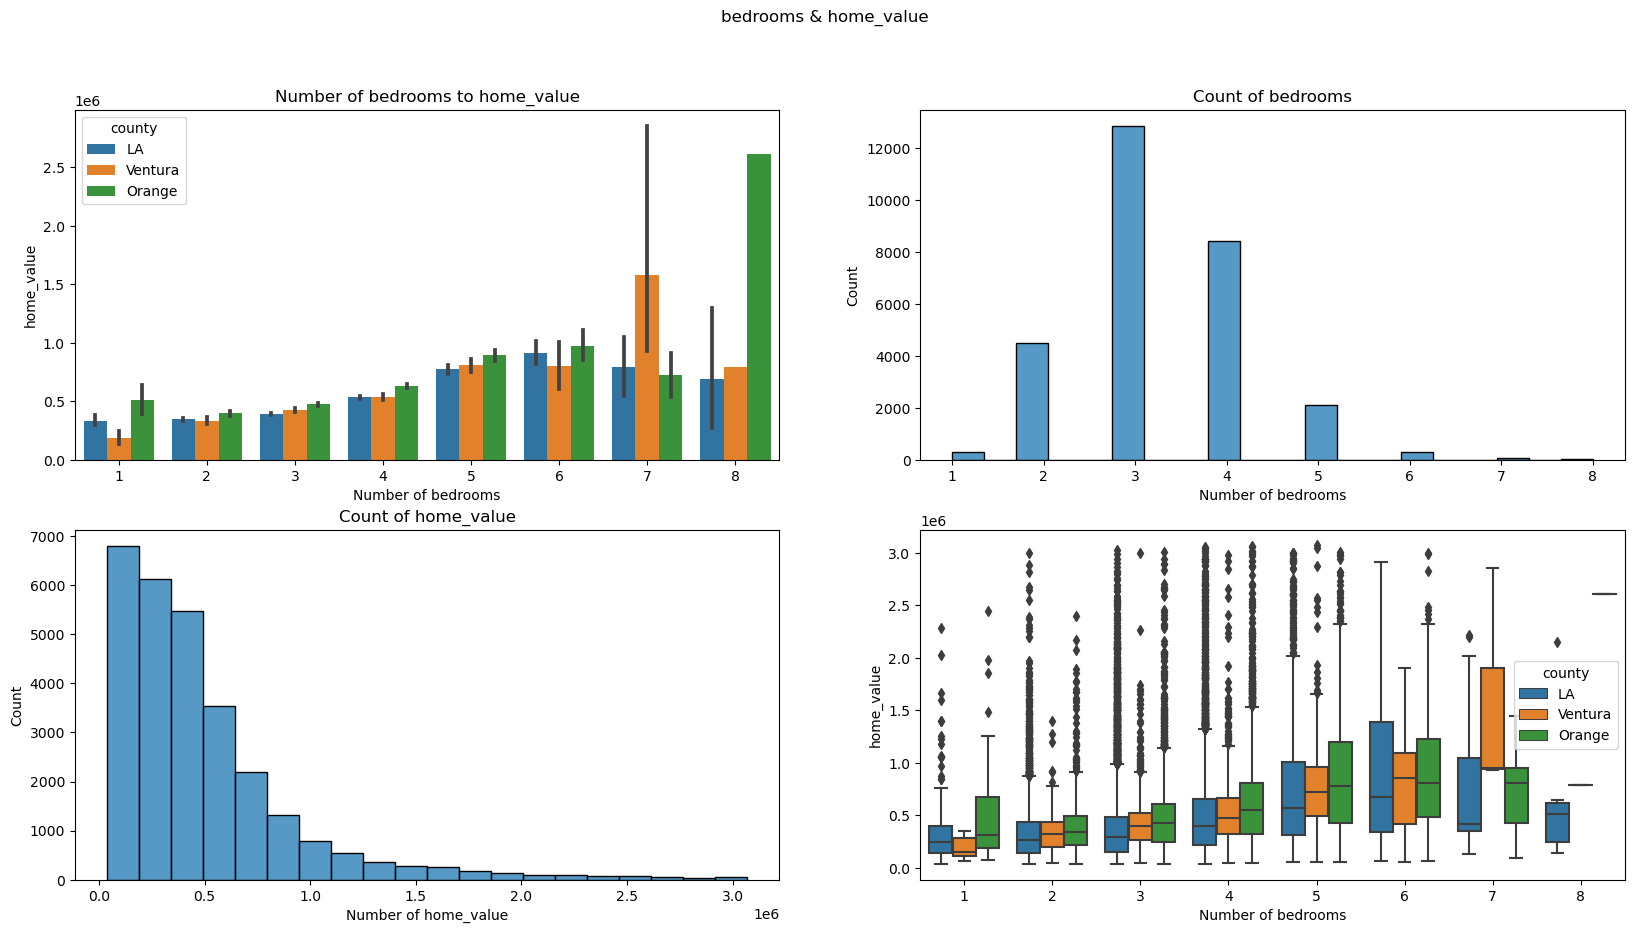

In [7]:
# run category and continuous graph function for visuals
w.catcont_four_graphs(train, 'bedrooms', 'home_value', 'county')

Can see that more bedrooms, higher home value, distributions seem different. Lots of outliers in teh data.

In [8]:
# Test to see if different distros
w.ttest_stat(train.bedrooms, train.home_value)

stat=-186.922, p=0.000
Probably different distributions


In [9]:
# Test to see if home values and bedrooms are dependent or independent of each other.
w.spear_stat(train.bedrooms, train.home_value)

stat=0.278, p=0.000
Probably dependent


### How do bathrooms affect home_value?

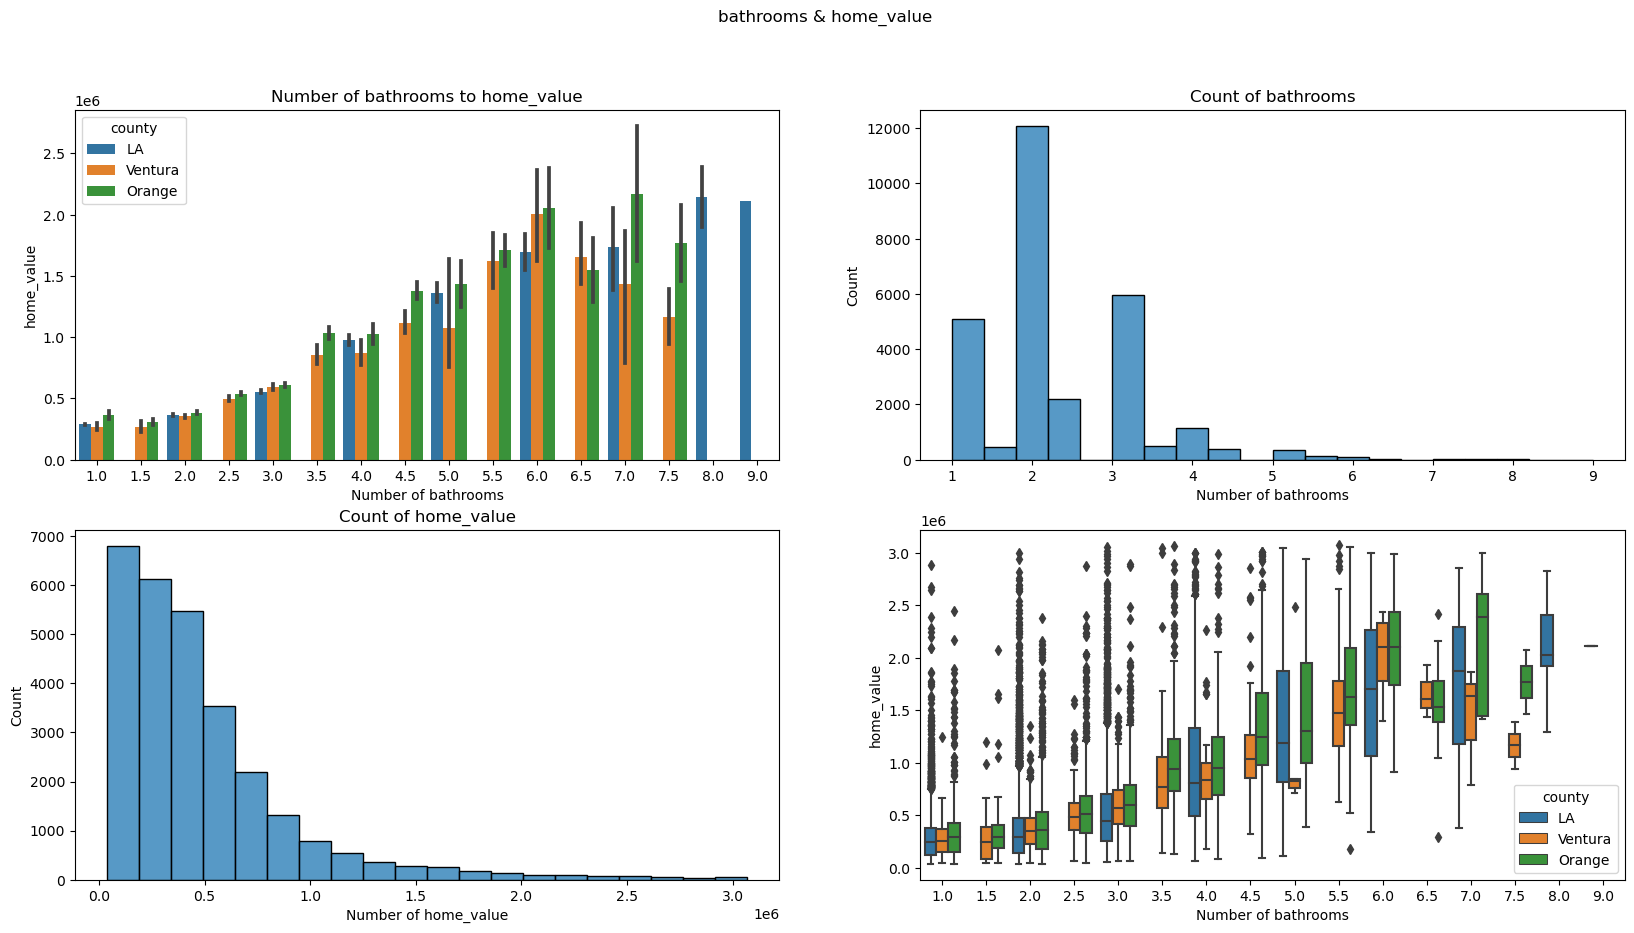

In [10]:
# run category and continuous graph function for visuals
w.catcont_four_graphs(train, 'bathrooms', 'home_value', 'county')

Can see that higher number of bathrooms increases the home value, disros seem to be skewed to right on both. Lots of outliers.

In [11]:
# Test for similar distributions.
w.ttest_stat(train.bathrooms, train.home_value)

stat=-186.923, p=0.000
Probably different distributions


In [12]:
# Test to see if home values and bathrooms are dependent or independent of each other.
w.spear_stat(train.bathrooms, train.home_value)

stat=0.464, p=0.000
Probably dependent


### How doe finished area affect home_value?

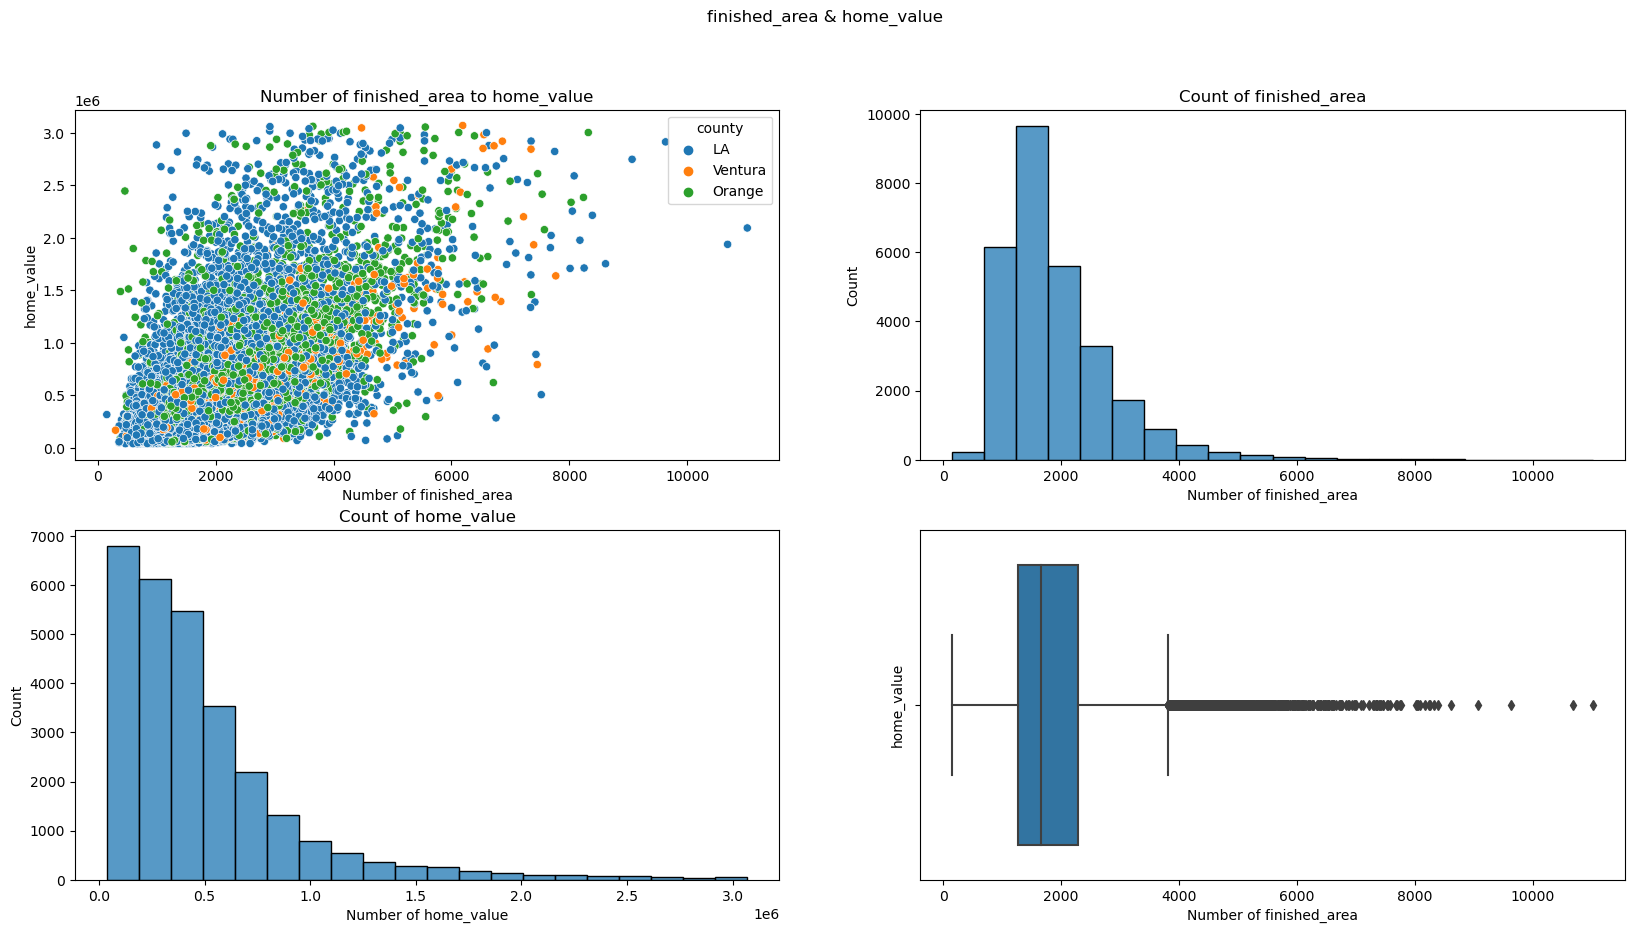

In [13]:
# run continous var graphs function for visualization
w.contcont_four_graphs(train, 'finished_area', 'home_value', 'county')

Can see that the distributions look to be both skewed right but lets check them.

In [14]:
# Test for similar distributions.
w.ttest_stat(train.finished_area, train.home_value)

stat=-186.191, p=0.000
Probably different distributions


In [15]:
# Test to see if home values and finisher area are dependent or independent of each other.
w.spear_stat(train.finished_area, train.home_value)

stat=0.505, p=0.000
Probably dependent


## Does having a garage affect the home value?

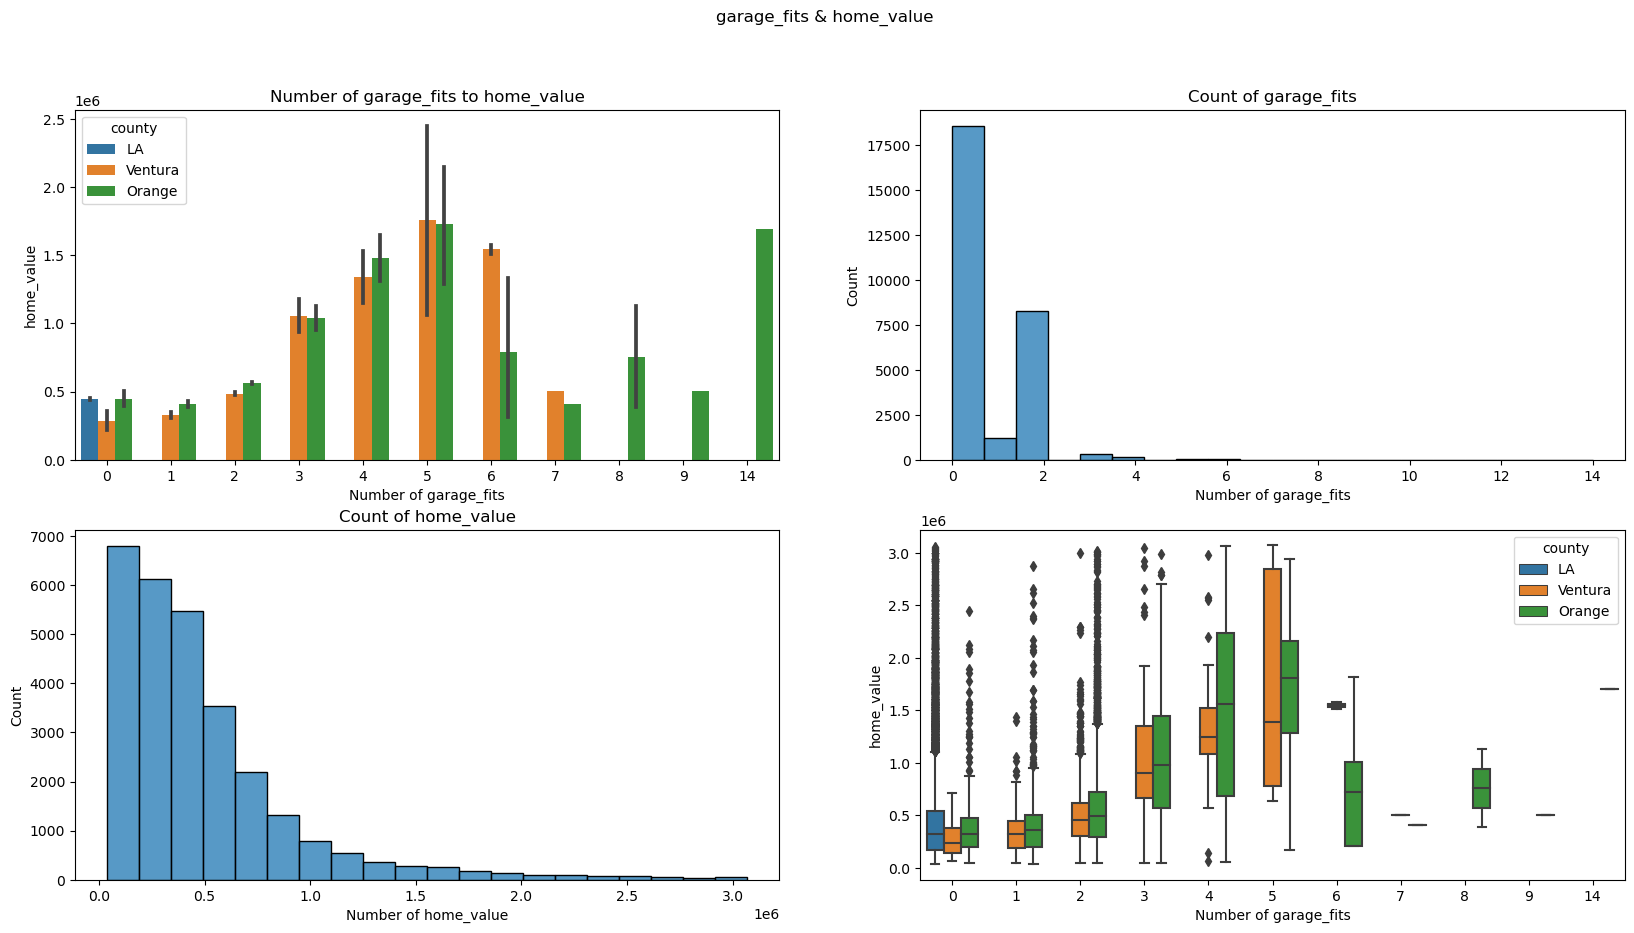

In [16]:
# run category and continuous graph function for visuals
w.catcont_four_graphs(train, 'garage_fits', 'home_value', 'county')

Appears that there is either very limited data from 'LA' County OR 'LA' doesn't have garages. I think there is too much unknown to use this data for modeling.

In [17]:
# Test to see if home values and garages are dependent or independent of each other.
w.spear_stat(train.garage_fits, train.home_value)

stat=0.212, p=0.000
Probably dependent


## Exploration Summary

Can see from the graphs and stats tests above, that there is some dependency on how many bedrooms, bathrooms, and how much finished area there is that dictates home_value. We will use these 3 features in the modeling. We will not be using garage_fits or any of the other features in them.

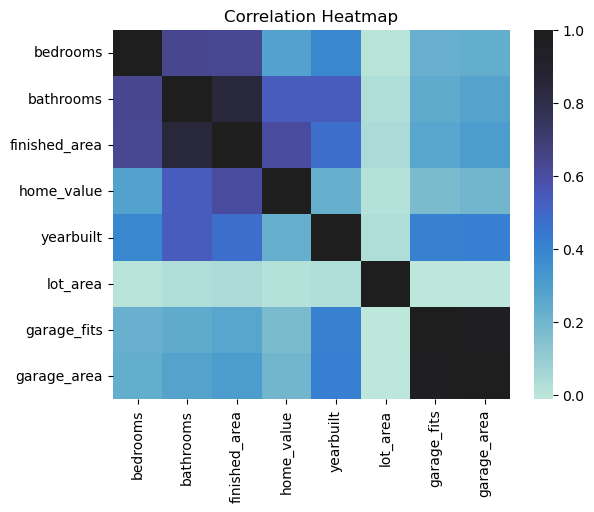

In [18]:
# Further conclude that from the correlation heatmap
w.corr_heat(train, 'county')

## Modeling

Split the X and Y variables, then made a copy, and scaled them

In [19]:
X_train, y_train, X_validate, y_validate, X_test, y_test = w.model_prep_zillow(train, validate, test, 'home_value')

In [20]:
X_train_scaled, X_valid_scaled, X_test_scaled = w.model_prep_zillow_scaled(X_train, X_validate, X_test)

In [21]:
# Calc a baseline for models
baseline= y_train.mean()
baseline

483350.5956445381

In [22]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([483350.59564454, 483350.59564454, 483350.59564454, 483350.59564454,
       483350.59564454])

In [23]:
rmse, r2 = w.metrics_reg(y_train, baseline_array)
rmse, r2

(436299.2747071282, 0.0)

In [24]:
# Create a dataframe to hold model results
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.0


### Model 1: Multiple Regression

What feature is the best from RFE?

In [25]:
X_train_rfe, X_val_rfe = w.get_best_feat_rfe(X_train_scaled, X_valid_scaled, y_train, 1)

selected top feature: ['finished_area']


Model ran with 3 Features, 'bedrooms', 'bathrooms', and finished_area.

In [26]:
rmse, r2, pred_lr1= w.get_lr(X_train_scaled, X_valid_scaled, y_train, y_validate, 3)
rmse, r2

selected top feature: ['bedrooms' 'bathrooms' 'finished_area']


(338239.85815456643, 0.3764368451033524)

In [27]:
metrics_df.loc[1] = ['Line Reg', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437


### Model 2: LassoLars

In [28]:
rmse, r2, pred_lars= w.get_lasso(X_train_scaled, X_valid_scaled, y_train, y_validate)
rmse, r2

(338239.8374247037, 0.3764369215365573)

In [29]:
#add to my metrics df
metrics_df.loc[2] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437


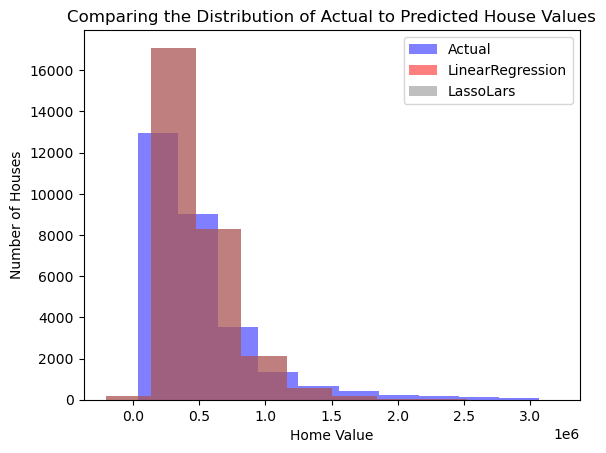

In [30]:
w.act_lr_lar_hist(y_train, pred_lr1, pred_lars)

### Model 3: Polynomial Regression 2 Degree

In [31]:
rmse, r2, pred_pr = w.get_poly(X_train_scaled, X_valid_scaled, y_train,y_validate, 2)
rmse, r2

(335612.3315603228, 0.38608718573431466)

In [32]:
#add to my metrics df
metrics_df.loc[3] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437
3,poly_2,335612.331560,0.386087


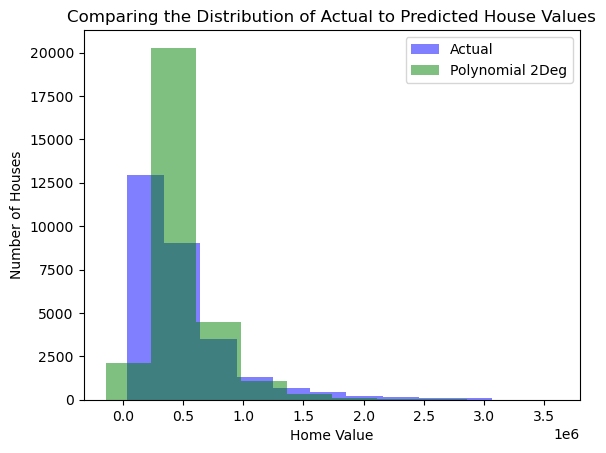

In [33]:
w.act_ploy2_hist(y_train, pred_pr)

### Model 4: Polynomial Regression 3 Degree

In [34]:
rmse, r2, pred_pr = w.get_poly(X_train_scaled, X_valid_scaled, y_train,y_validate, 3)
rmse, r2

(335040.36504114565, 0.38817792156117237)

In [35]:
#add to my metrics df
metrics_df.loc[4] = ['poly_3', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437
3,poly_2,335612.331560,0.386087
4,poly_3,335040.365041,0.388178


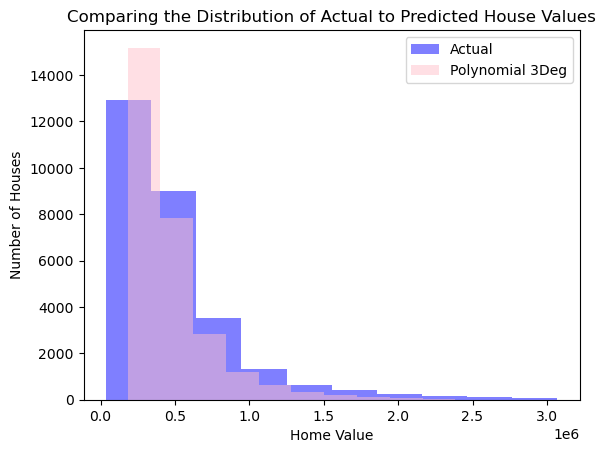

In [36]:
w.act_poly3_hist(y_train, pred_pr)

Overall Results Between the models & Graphs

### Model 4: Test Results

In [37]:
# Ran test function and pulled out pred_test_pr for visualization
rmse, r2, pred_test_pr = w.get_poly_test(X_train_scaled, X_valid_scaled, X_test_scaled, y_train, y_validate, y_test, 3)
rmse, r2

(338550.58523909637, 0.39656965253577825)

In [38]:
# added to model result dataframe
metrics_df.loc[5] = ['Test_poly_3', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437
3,poly_2,335612.331560,0.386087
4,poly_3,335040.365041,0.388178
5,Test_poly_3,338550.585239,0.396570


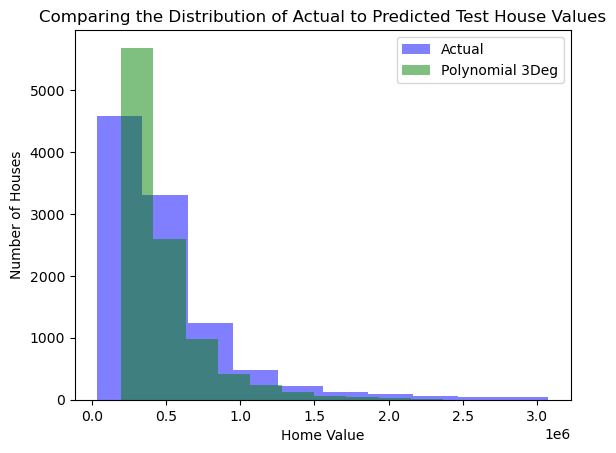

In [39]:
w.act_poly3_hist_test(y_test, pred_test_pr)

Ran the Test set on Model 4, Polynomial Regression degree of 3 and got an r2 of 39.7%

## Conclusion

### Summary

 After running the models, the Polynomial Regression with a degree of 3 ran the best. After the scaled test data was ran through, we came out with an r2 of 39.7%. Its higher than the other models, however, it is still quite low and only within 340k of the correct home value price which is alot of error. 

### Recommendations

* I would recommend possibly splitting up the data into counties and adding more Features to the data collected in order to potentially predict Home Values in the future.
* Simply having just bedrooms, bathrooms, and finished area are not enough to predict home values 